# <center> Introduction to Reinforcement Learning</center>

# 1. Setup

#### Let us first make sure that all the required dependencies are installed

In [1]:
import sys
!{sys.executable} -m pip install gym

In [2]:
!git clone https://github.com/Tobias-Fischer/RVSS2022.git

Cloning into 'RVSS2022'...
remote: Enumerating objects: 684, done.
remote: Counting objects: 100% (684/684), done.
remote: Compressing objects: 100% (551/551), done.
remote: Total 684 (delta 379), reused 356 (delta 125), pack-reused 0
Receiving objects: 100% (684/684), 39.30 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (379/379), done.


#### Import dependencies

In [3]:
# %matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle

import sys
import os
sys.path.insert(0, os.path.abspath('RVSS2022/Reinforcement_Learning/Support'))

from gym_simple_gridworlds.envs.grid_env import GridEnv
from gym_simple_gridworlds.envs.grid_2dplot import *
from gym_simple_gridworlds.helper import *

from IPython.core.display import display, HTML, Image

# 2. Elements of an MDP (Grid World Example)

Recall the grid in which our robot lives

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/GridWorldExample.png)


- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (row=1,col=0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (-1,0)
    - Down: (1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state

We have defined the class ``GridEnv`` to represent our Grid World MDP. **Take a look at the attributes of this class by placing the cursor somewhere on the class' name and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.**

## 2.1 Create Environment and Explore its Attributes

The noise parameter corresponds to the probability of a change of direction when an action is taken (e.g., going left/right when agent decides to move up/down)

In [4]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)

### State and Action Spaces

Let's take a look at the state and action spaces of our environment

In [5]:
# State (or observation) space
print(grid_world.observation_space)
print(grid_world.get_states())
print()

# Action space
print(grid_world.action_space)
print(grid_world.get_actions())

Discrete(11)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Discrete(4)
[0, 1, 2, 3]


### Transition Function

Let's take a look at the current state transition function. Some things to keep in mind regarding the transition function:

1. Given that $\mathcal{T}: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \rightarrow \mathbb{R}$, the ``state_transitions`` attribute of the class ``GridEnv`` corresponds to a 3-Dimensional numpy array of size $11\times4\times11$.
2. With a noise attribute set to 0.2, at state 5, if the agent chooses to move up, it will end up at:
    - state 2 with $80\%$ probability,
    - state 6 with $10\%$ probability, or
    - state 5 with $10\%$ probability

In [6]:
print(grid_world.state_transitions[5,0])

[0.  0.  0.8 0.  0.  0.1 0.1 0.  0.  0.  0. ]


### Living Reward and Reward Function

Let's now take a quick look at the living reward (i.e., running cost) and reward function $\mathcal{R}: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$.

1. Living reward corresponds to the attribute ``living_rewards`` of the class ``GridEnv`` and is represented as an 1-Dimensional numpy array
2. The reward function corresponds to the attribute ``rewards`` of the class ``GridEnv`` and is also represented as a 2-Dimensional numpy array of size $11\times4$

In [7]:
# Living rewards
print("Living rewards for all states:\n{}\n".format(grid_world.immediate_rewards))



Living rewards for all states:
[-0.04 -0.04 -0.04  1.   -0.04 -0.04 -1.   -0.04 -0.04 -0.04 -0.04]



### Policy

Let's see the path and total reward of an agent moving on our grid world according to some random policy


Decoded policy
 [[ 3.  3.  3. -1.]
 [ 0. nan  0. -1.]
 [ 0.  2.  0.  2.]]


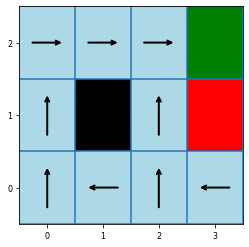

In [76]:
# We randomly pick an action to take in each state
# Generate an initial random policy
#test_policy = define_random_policy(grid_world)
#encoded_test_policy = encode_policy(grid_world,test_policy)
#test_policy_matrix = decode_policy(grid_world,encoded_test_policy)


# Or, we could specify our own policy
test_policy_matrix = np.array([[3,      3,  3,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      2,  0,   2]])
encoded_test_policy = encode_policy(grid_world,test_policy_matrix)


plot_policy(grid_world,test_policy_matrix)
print("Decoded policy\n", test_policy_matrix)

Let's now apply this policy and observe the agent's behavior (blue dot in the figure shown below).

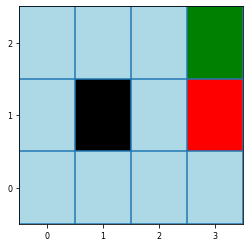

In [77]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.99, noise=0.2, living_reward=-0.04)
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
grid_world.reset() #can reset to start from a different initial condition
cur_state = grid_world.cur_state
path_to_plot = []

while not done:
    _, cur_reward, done, _ = grid_world.step(int(test_policy_matrix[cur_state[0], cur_state[1]]))
    cur_state = grid_world.cur_state
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

In [78]:
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)
HTML(ani.to_html5_video())

### 2.2 Summary and Code Correspondance

$\gamma$

<table style="width:20%">
<thead>
<tr>
<th style="width:150px;font-size:20px;text-align:center;">MDP Notation (from notes)</th>
<th colspan=2 style="width:250px;font-size:20px;text-align:center;">GridEnv</th>
</tr>
    <tr>
        <td></td>
        <th style="font-size:15px;text-align:center;">Class attribute</th>
        <th style="font-size:15px;text-align:center;">Class method</th>
    </tr>
</thead>
<tbody>
<tr>
    <td style="text-align:left;">$\mathcal{S} = \{0,\dots,10\}$</td>
    <td style="text-align:left;">observation_space</td>
    <td style="text-align:left;">get_states()</td>
</tr>
<tr>
    <td style="text-align:left;">$\mathcal{A} = \{\text{up}, \text{down}, \text{left}, \text{right} \}$</td>
    <td style="text-align:left;">action_space</td>
    <td style="text-align:left;">get_actions()</td>
</tr>
<tr>
    <td style="text-align:left;">$\mathcal{T}(s, a, s')$</td>
    <td style="text-align:left;">state_transitions</td>
    <td></td>
</tr>
<!-- <tr>
    <td style="text-align:left;">$\mathcal{R}(s)$</td>
    <td style="text-align:left;">immediate_rewards</td>
    <td></td>
</tr>-->
    <tr>
    <td style="text-align:left;">$\mathcal{R}(s,a)$</td>
    <td style="text-align:left;">rewards</td>
    <td></td>
</tr>
</table>

# 3. Iterative Policy Evaluation

Recall the definition of the iterative policy evaluation algorithm

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/IterativePolicyEvaluation.png)

Let's now compute the value function of the same policy $\pi$

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/example_policy.png)

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.99$ (class attribute ``gamma=0.99``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- A non-zero living cost and big rewards are obtained at terminal states (class attribute ``living_reward=-0.04``)

We have defined the helper function ``encode_policy()`` to encode the policy $\pi$ shown in the image above. The return variable ``policy_pi`` is a dictionary of dictionaries, where each element corresponds to the probability of selecting an action $a$ at a given state $s$

Keep in mind that each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3.

In [79]:
grid_world = GridEnv(gamma=0.99, noise=0.2, living_reward=-0.04)
policy_pi = encoded_test_policy

print("Action probabilities at state 0 are:\n{}".format(dict(policy_pi[2])))

Action probabilities at state 0 are:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}


Given the policy $\pi$, let's now compute its state-value function using iterative policy evaluation.

**TODO**: 
Complete the computation of value function update for each state. We have decomposed this computation into 2 steps:

1. Compute discounted sum of state values of all successor states: $\text{discounted_v} = \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v(s')$ for each action


2. Compute expectation over all actions: $\sum_{a \in \mathcal{A}}\pi(a|s)(\mathcal{R}(s,a) + \text{discounted_v})$ 


**Keep in Mind**: Correspondance between the mathematical notation and implemented code


<table style="width:20%">
<thead>
<tr>
<th style="width:150px;font-size:20px;text-align:center;">Notation in Slides</th>
<th colspan=2, style="width:450px;font-size:20px;text-align:center;">Code</th>
</tr>
    <tr>
        <td></td>
        <th style="font-size:15px;text-align:left;">Variable/Attribute</th>
        <th style="font-size:15px;text-align:left;">Type</th>
    </tr>
</thead>
<tbody>
<tr>
    <td style="text-align:left;">$\gamma$</td>
    <td style="text-align:left;font-size:15px;">grid_world.gamma</td>
    <td>float</td>
</tr>
<tr>
    <td style="text-align:left;">$\mathcal{T}(s, a, s')$</td>
    <td style="text-align:left;font-size:15px;">grid_world.state_transitions[idx_s, idx_a, idx_s]</td>
    <td>numpy 3d-array</td>
</tr>
<tr>
    <td style="text-align:left;">$\mathcal{R}(s, a)$</td>
    <td style="text-align:left;font-size:15px;">grid_world.rewards[idx_s, idx_a]</td>
    <td>numpy 2d-array</td>
</tr>
<tr>
    <td style="text-align:left;">$\pi(a|s)$</td>
    <td style="text-align:left;font-size:15px;">policy_pi[idx_s][idx_a]</td>
    <td>dict of dict</td>
</tr>
<tr>
    <td style="text-align:left;">$v_\pi(s)$</td>
    <td style="text-align:left;font-size:15px;">v[idx_s]</td>
    <td>dict</td>
</tr>
</table>

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}


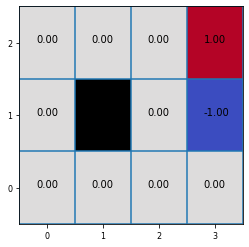

In [85]:
def policy_evaluation(grid_env, policy, plot=False, threshold=0.00001):
    
    """
    This function computes the value function for a policy pi in a given environment grid_env.
    
    :param grid_env (GridEnv): MDP environment
    :param policy (dict - stochastic form): Policy being evaluated
    :return: (dict) State-values for all non-terminal states
    """
        
    # Obtain list of all states in environment
    v = {s: 0.0 for s in grid_env.get_states()}
    theta = threshold
    delta = 1000

    while delta > theta:
        delta = 0.0
        # For all states
        for s in v.keys():

            old_v = v[s]
            new_v = 0

            # For all actions
            for a in grid_env.get_actions():
                discounted_v = 0

                # For all states that are reachable from s with action a
                for s_next in grid_env.get_states():
                    # TODO 1: Compute discounted sum of state values for all successor states
                    discounted_v += 0

                    
                # TODO 2: Compute expectation over all actions
                new_v += 0

            v[s] = new_v
            delta = max(delta, np.abs(old_v - new_v))

    if plot:
        plot_value_function(grid_env, v)
        
    return v
        
        
# Call the policy evalution function
v = policy_evaluation(grid_world, policy_pi, plot=True)
print(v)

# 4. Policy Iteration

Recall the definition of the policy iteration algorithm

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/PolicyIteration.png)

Starting with a random policy, let's find the optimal policy for a grid world environment with attributes:

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.99$ (class attribute ``gamma=0.99``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=-0.04``)

We will first define some helper methods:
- ``one_step_look_ahead(grid_env, state, value_function)``, this method computes the action-value function for a state $s$ given the state-value function $v$. This corresponds to $\mathcal{R}(s,a) + \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v_\pi(s')\, \forall \, a \in \mathcal{A}$


- ``update_policy(grid_world, policy, value_function)``, this method updates the current policy $\pi$ given the state-value function $v$ by taking the action $a$ with the highest action-value. 


- ``define_random_policy(grid_env)`` in script ``helper.py``, this method generates a random policy for environment ``grid_env``

In [81]:
def one_step_look_ahead(grid_env, state, value_function):
    """
     Compute the action-value function for a state $s$ given the state-value function $v$.
     
     :param grid_env (GridEnv): MDP environment
     :param state (int): state for which we are looking one action ahead
     :param value_function (dict): state-value function associated to a given policy py
     
     :return: (np.array) Action-value function for all actions available at state s
    """
    action_values = []
    
    for action in grid_env.get_actions():
        discounted_value = 0
        for s_next in grid_env.get_states():
             discounted_value += grid_env.state_transitions[state, action, s_next] * value_function[s_next]
        
        q_a = grid_env.rewards[state, action] + grid_env.gamma * discounted_value
        action_values.append(q_a)
    
    return np.array(action_values)

In [82]:
def update_policy(grid_env, cur_policy, value_function):
    """
     Update a given policy based on a given value_function
     
     :param grid_env (GridEnv): MDP environment
     :param cur_policy (matrix form): Policy to update
     :param value_function: state-value function associated to a policy cur_policy
     
     :return: (dict) Updated policy
    """
    
    states = grid_env.get_states(exclude_terminal=True)
    
    for s in states:
        # Obtain state-action values for state s using the helper function one_step_look_ahead
        action_values = one_step_look_ahead(grid_env, s, value_function)
        
        # Find (row, col) coordinates of cell with index s
        row, col = np.argwhere(grid_env.grid == s)[0]
        
        cur_policy[row, col] = np.argmax(action_values)
        
    return cur_policy

Let's now define the policy iteration core algorithm.

**TODO**: Complete the main steps of the policy iteration algoritm.
- Use ``policy_evaluation(.)`` to compute the state-value function of a given policy
- Use ``update_policy(.)`` to obtain an updated policy

In [86]:
def policy_iteration(grid_env, policy, plot=False):
    """
    This function iteratively updates a given policy pi for a given environment grid_env until convergence to optimal policy
    
    :param grid_env (GridEnv): MDP environment
    :param policy (matrix from): Deteministic policy being updated
    :return: (dict) State-values for all non-terminal states
    """
    prev_policy = np.zeros(policy.shape)
    
    while not np.all(np.equal(prev_policy, policy)):
        
        # Encode policy. This policy representation is needed for policy evaluation
        encoded_policy = encode_policy(grid_env, policy)
        # Set prev_policy to current policy
        prev_policy = policy.copy()
        
        #TODO: Complete the remaining steps
        # 1. Evaluate the given policy (policy_evaluation expects an mdp and the enconded_policy as arguments)
        
        # 2. Update policy using helper function update_policy
        
        
    if plot:
        plot_policy(grid_env, policy)
    
    return policy

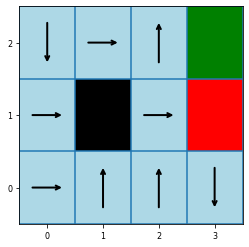

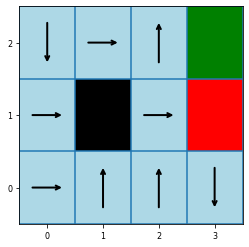

In [87]:
# Create a grid world mdp
grid_world = GridEnv(gamma=0.99, noise=0.2, living_reward=-0.04)

# Generate an initial random policy
initial_policy = define_random_policy(grid_world)
plot_policy(grid_world,initial_policy)

# Compute optimal policy using policy iteration
optimal_policy = policy_iteration(grid_world, initial_policy, plot=True)